In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [ ]:
df=pd.read_csv("Train_data.csv")
df.head() #Data size is very small so you can try various techniques on it

,id,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,release_date,speechiness,tempo,valence,year,duration-min,popularity
0,2015,0.949,0.235,0.0276,No,0.9270,5,0.513,-27.398,Major,01-01-1947,0.0381,110.838,0.0398,1947,3.0,very low
1,15901,0.855,0.456,0.4850,No,0.0884,4,0.151,-10.046,Major,13-11-2020,0.0437,152.066,0.8590,2020,2.4,low
2,9002,0.827,0.495,0.4990,No,0.0000,0,0.401,-8.009,Minor,01-01-1950,0.0474,108.004,0.7090,1950,2.6,very low
3,6734,0.654,0.643,0.4690,No,0.1080,7,0.218,-15.917,Major,30-04-1974,0.0368,83.636,0.9640,1974,2.4,low
4,15563,0.738,0.705,0.3110,No,0.0000,5,0.322,-12.344,Major,01-01-1973,0.0488,117.260,0.7850,1973,3.4,average


In [ ]:
# Fortunately not missing values
df.isna().sum()

id                  0
acousticness        0
danceability        0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
duration-min        0
popularity          0
dtype: int64

In [ ]:
# Know the datatypes, number of unique values in each feature and their percent-wise distribution
for col in df.columns:
    print(col,df[col].dtypes,df[col].nunique())
    if df[col].nunique()<=15:
        a=df[col].value_counts()
        a=pd.concat([a,a/a.sum()*100],axis=1)
        a.columns=[col,'percentage']
        
        print(a)
    print("-"*50)
    
    
### High imbalance of samples between songs of high popularity vs the rest

id int64 12227
--------------------------------------------------
acousticness float64 2714
--------------------------------------------------
danceability float64 898
--------------------------------------------------
energy float64 1396
--------------------------------------------------
explicit object 2
     explicit  percentage
No      10906   89.196042
Yes      1321   10.803958
--------------------------------------------------
instrumentalness float64 3658
--------------------------------------------------
key int64 12
     key  percentage
0   1481   12.112538
7   1464   11.973501
2   1336   10.926638
9   1262   10.321420
5   1170    9.568987
1   1037    8.481230
4    923    7.548867
10   842    6.886399
11   825    6.747362
8    732    5.986751
6    657    5.373354
3    498    4.072953
--------------------------------------------------
liveness float64 1477
--------------------------------------------------
loudness float64 8718
--------------------------------------------------

In [ ]:
# BAsic stats of numerical features to get the hight level feel of features and detect outliers 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,12227.0,8094.034350,4690.929822,1.000000,4026.00000,8093.000000,12180.00000,16227.000
acousticness,12227.0,0.430578,0.366893,0.000001,0.05895,0.354000,0.80500,0.996
danceability,12227.0,0.556353,0.175373,0.000000,0.43800,0.569000,0.68500,0.980
energy,12227.0,0.522129,0.262482,0.000020,0.30300,0.534000,0.73900,1.000
instrumentalness,12227.0,0.149321,0.297954,0.000000,0.00000,0.000115,0.05565,1.000
key,12227.0,5.205202,3.526954,0.000000,2.00000,5.000000,8.00000,11.000
liveness,12227.0,0.201365,0.173987,0.014700,0.09620,0.132000,0.25200,0.997
loudness,12227.0,-10.668687,5.506888,-43.738000,-13.65600,-9.584000,-6.57150,1.006
speechiness,12227.0,0.097680,0.155895,0.000000,0.03470,0.045600,0.07890,0.968
tempo,12227.0,118.167495,30.200064,0.000000,95.05050,116.915000,136.10850,216.843


In [ ]:
# label encode the Categorical features
df=df.replace({"explicit":{"Yes":1,"No":0},
          "mode":{"Major":1,"Minor":0},
           "popularity":{'very low': 1, 'low': 2, 'average': 3, 'high':4, 'very high': 5},
              })

In [ ]:
# correlation with target variable
df.corr()["popularity"].sort_values()

acousticness       -0.407964
instrumentalness   -0.317268
speechiness        -0.122614
liveness           -0.103116
mode               -0.039218
duration-min       -0.009381
valence            -0.005329
id                  0.013905
key                 0.014269
tempo               0.076751
danceability        0.220554
explicit            0.260153
energy              0.327218
loudness            0.413219
year                0.635493
popularity          1.000000
Name: popularity, dtype: float64

In [ ]:
# Get the release date to make new other interseting features that might be beneficial for our model
release_date=pd.to_datetime(df.release_date)

# removing the id and release date
df=df.drop(columns=["id","release_date"])


In [ ]:
#creating temporal dependencies features that might discriminate target varibale well
df["day"]=release_date.dt.day
df["day_of_week"]=release_date.dt.dayofweek
df["day_od_year"]=release_date.dt.dayofyear
df["month"]=release_date.dt.month
df["week_of_year"]=release_date.dt.weekofyear

df["day_bin"]=1
df.day_bin[df.day.isin([1,31])]=0

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,duration-min,popularity,day,day_of_week,day_od_year,month,week_of_year,day_bin
0,0.9490,0.2350,0.0276,0,0.927000,5,0.513,-27.398,1,0.0381,110.838,0.03980,1947,3.0,1,1,2,1,1,1,0
1,0.8550,0.4560,0.4850,0,0.088400,4,0.151,-10.046,1,0.0437,152.066,0.85900,2020,2.4,2,13,4,318,11,46,1
2,0.8270,0.4950,0.4990,0,0.000000,0,0.401,-8.009,0,0.0474,108.004,0.70900,1950,2.6,1,1,6,1,1,52,0
3,0.6540,0.6430,0.4690,0,0.108000,7,0.218,-15.917,1,0.0368,83.636,0.96400,1974,2.4,2,30,1,120,4,18,1
4,0.7380,0.7050,0.3110,0,0.000000,5,0.322,-12.344,1,0.0488,117.260,0.78500,1973,3.4,3,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12222,0.0408,0.8090,0.8010,0,0.000000,1,0.353,-5.461,1,0.4070,81.940,0.74400,2014,3.4,3,7,1,7,1,2,1
12223,0.9120,0.4510,0.2400,0,0.000002,1,0.175,-14.014,1,0.0351,134.009,0.70100,1959,2.0,5,1,3,1,1,1,0
12224,0.3280,0.5510,0.5640,0,0.002950,2,0.352,-9.298,0,0.0338,124.883,0.89000,1984,2.5,2,1,6,1,1,52,0
12225,0.1220,0.0608,0.9390,0,0.991000,1,0.912,-26.324,1,0.1180,73.234,0.00558,2017,3.1,4,1,4,244,9,35,0


In [ ]:
# seeing the statistics class wise of target label
df.groupby(["popularity"])["acousticness"].describe()

,count,mean,std,min,25%,50%,75%,max
popularity,,,,,,,,
average,2912.0,0.330648,0.320610,0.000001,0.033125,0.2250,0.59725,0.995
high,2606.0,0.258232,0.281785,0.000002,0.028025,0.1440,0.42000,0.995
low,3118.0,0.433729,0.344918,0.000001,0.081375,0.4085,0.76400,0.996
very high,369.0,0.272311,0.274206,0.000147,0.052200,0.1770,0.41400,0.978
very low,3222.0,0.675366,0.366376,0.000001,0.382250,0.8600,0.97800,0.996


##### Analysing each features w.r.t each class of target variable graphically

In [ ]:
df.key

0        5
1        4
2        0
3        7
4        5
        ..
12222    1
12223    1
12224    2
12225    1
12226    1
Name: key, Length: 12227, dtype: int64

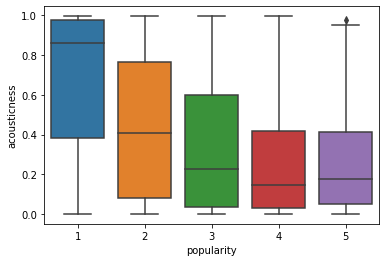

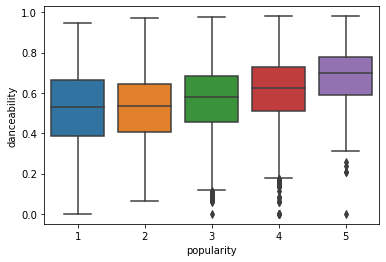

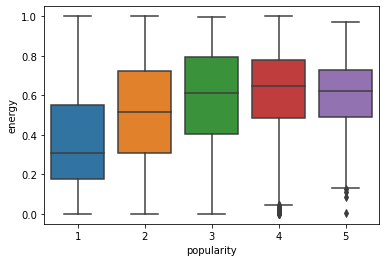

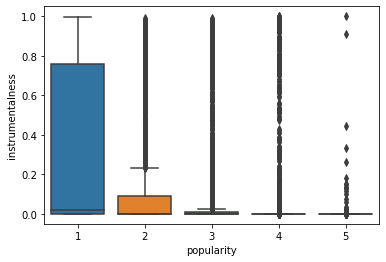

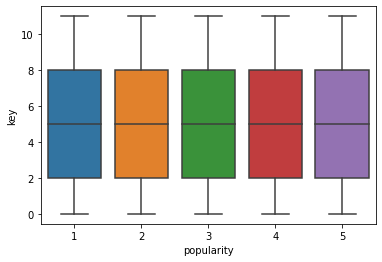

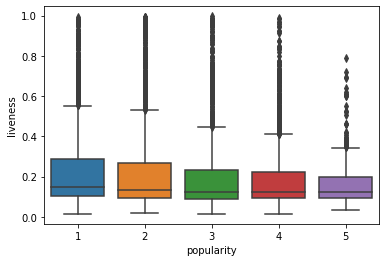

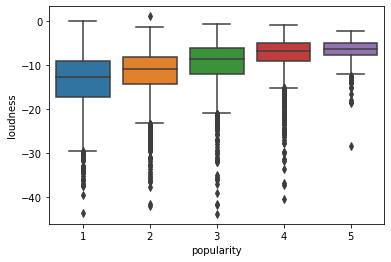

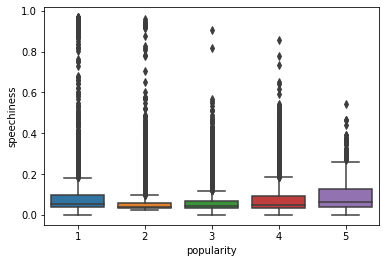

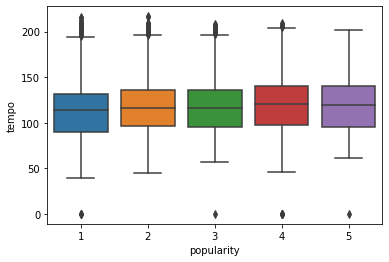

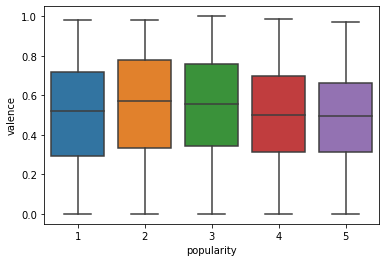

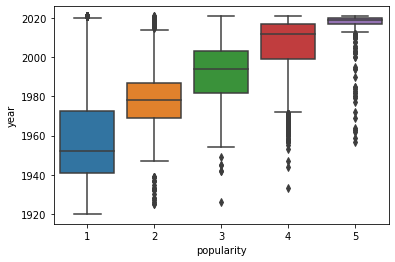

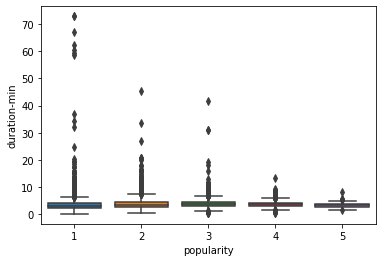

In [ ]:
# let's see outliers and dist in Numerical features
num_col=['acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'year', 'duration-min']

for i,c in enumerate(num_col):
    sns.boxplot(y=df[c],x=df.popularity)
    plt.show()

In [ ]:
# Plot distribution of a features for each class
def distWithPopularity(f,p):
    for val in p.unique():
        sns.distplot(f[p==val],label=str(val))
    plt.legend(list(map(str,p.unique())))
    plt.show()

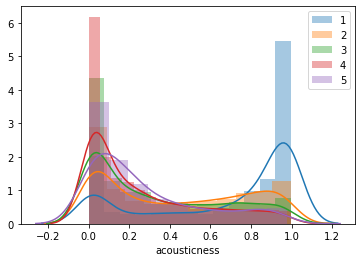

In [ ]:
distWithPopularity(df.acousticness,df.popularity)

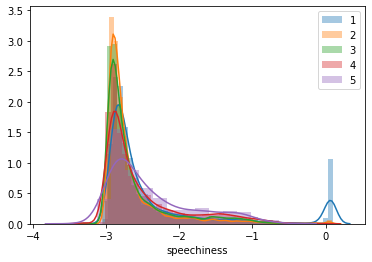

In [ ]:
distWithPopularity(np.log2(df.speechiness+0.1),df.popularity)

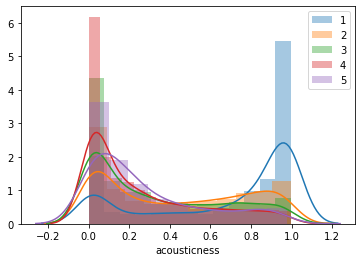

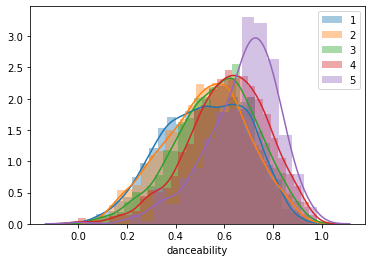

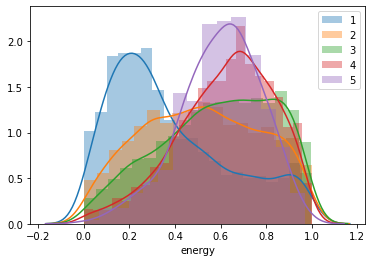

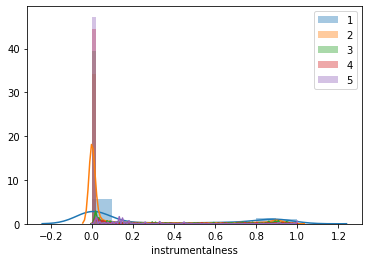

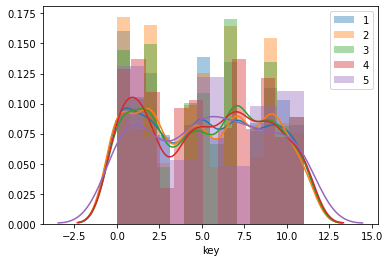

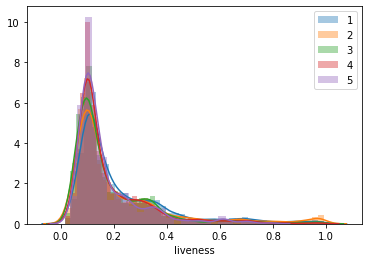

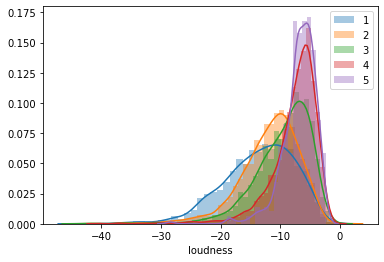

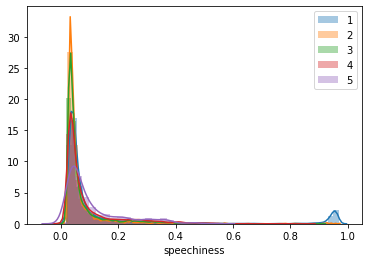

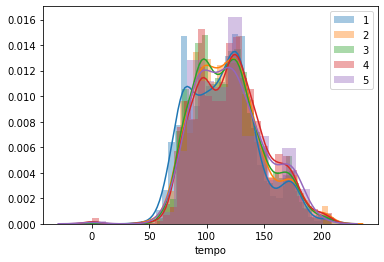

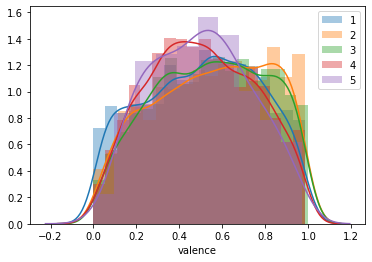

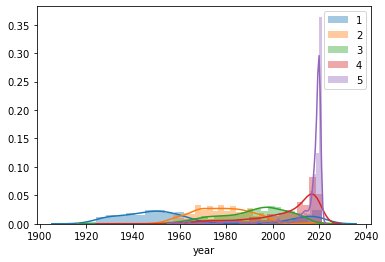

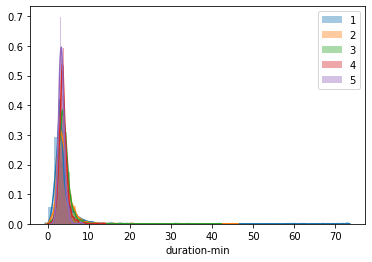

In [ ]:
for col in num_col:
    distWithPopularity(df[col],df.popularity)

In [ ]:

# df.day[~df.day.isin([1,31])]=2

<ipython-input-169-79d122d6d834>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.day_bin[df.day.isin([1,31])]=1


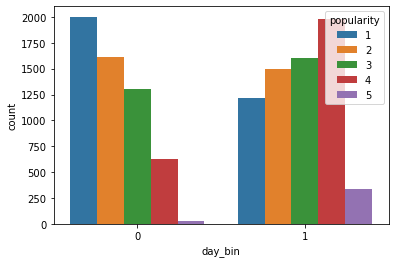

In [ ]:
# Here You can see the distribution of popularity is very much different for 0 and 1 day bin
# acting as a good discriminative feature
sns.countplot(x=df.day_bin,hue=df.popularity)

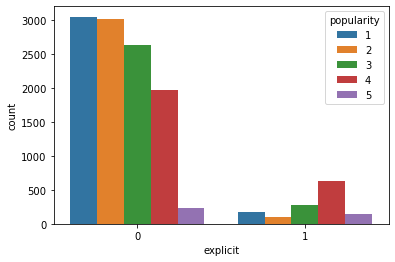

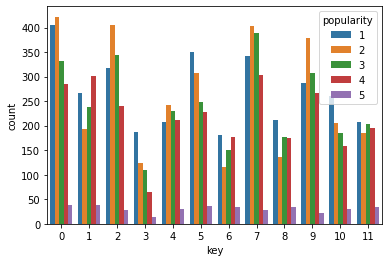

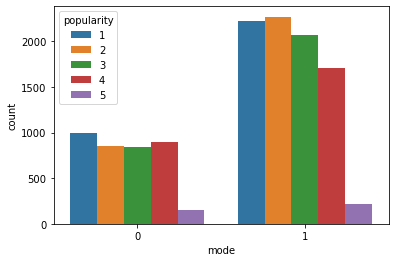

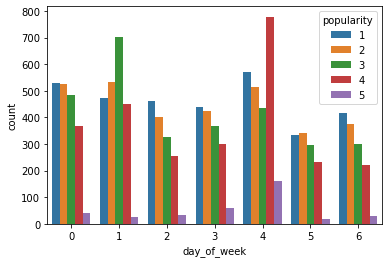

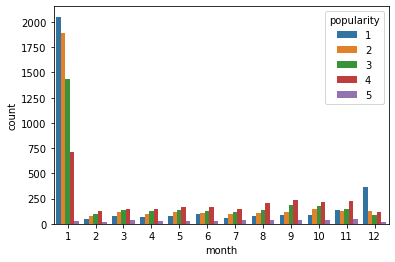

In [ ]:
cat_col=['explicit', 'key', 'mode', 'day_of_week', 'month']
for c in cat_col:
    sns.countplot(x=df[c],hue=df.popularity)
    plt.show()
    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix

X=df.drop(columns=["popularity"])
y=df.popularity
x_train,x_test,y_train,y_test=train_test_split(X,y,stratify=y,shuffle=True,test_size=0.2)


In [ ]:
# Applying baseline model without prameters tuning

def model(rmf,x,y,isval=False):
    if not isval:
        rmf.fit(x,y)
    y_pred=rmf.predict(x)
    if isval:
        print("\nValidation:")
    else:
        print("\nTrain:")
    print(classification_report(y,y_pred))
    print()
    print(confusion_matrix(y,y_pred))
    print("-"*50)
    return rmf

rmf=RandomForestClassifier() #model1
gbm=GradientBoostingClassifier() #model2

# Results on train and Validation after training on random forest classifier
rmf=model(rmf,x_train,y_train)
rmf=model(rmf,x_test,y_test,isval=True)


Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2577
           2       1.00      1.00      1.00      2494
           3       1.00      1.00      1.00      2330
           4       1.00      1.00      1.00      2085
           5       1.00      1.00      1.00       295

    accuracy                           1.00      9781
   macro avg       1.00      1.00      1.00      9781
weighted avg       1.00      1.00      1.00      9781


[[2577    0    0    0    0]
 [   0 2494    0    0    0]
 [   0    0 2330    0    0]
 [   0    0    2 2083    0]
 [   0    0    0    0  295]]
--------------------------------------------------

Validation:
              precision    recall  f1-score   support

           1       0.82      0.84      0.83       645
           2       0.55      0.68      0.61       624
           3       0.49      0.43      0.46       582
           4       0.64      0.60      0.62       521
           5       0.75   

In [ ]:

#same for gradient boosting
gbm=model(gbm,x_train,y_train)
gbm=model(gbm,x_test,y_test,isval=True)


Train:
              precision    recall  f1-score   support

           1       0.86      0.86      0.86      2577
           2       0.61      0.77      0.68      2494
           3       0.59      0.53      0.56      2330
           4       0.70      0.61      0.65      2085
           5       0.84      0.52      0.64       295

    accuracy                           0.69      9781
   macro avg       0.72      0.66      0.68      9781
weighted avg       0.70      0.69      0.69      9781


[[2209  147   75  140    6]
 [ 228 1913  330   20    3]
 [  76  755 1241  258    0]
 [  63  293  445 1264   20]
 [   4    9    6  124  152]]
--------------------------------------------------

Validation:
              precision    recall  f1-score   support

           1       0.79      0.84      0.81       645
           2       0.55      0.70      0.62       624
           3       0.52      0.45      0.49       582
           4       0.68      0.55      0.61       521
           5       0.50   

In [ ]:
d=dict(list(zip(X.columns[np.argsort(rmf.feature_importances_)[::-1]],rmf.feature_importances_[np.argsort(rmf.feature_importances_)[::-1]])))
plt.barh(list(d.keys()),list(d.values()),)

In [ ]:
def get_revenue(y_true,y_pred):
    bid2revenue={1:2,2:4,3:6,4:8,5:10}
    r1_l=[bid2revenue[bid]-bid for bid in y_true[y_pred==y_true]]
    r1=sum(r1_l)
    wrong_pred=[y_pred!=y_true]
    r2_l=[bid2revenue[a]-b if b>a else -b for a,b in zip(y_true[wrong_pred],y_pred[wrong_pred])]
    r2=sum(r2_l)
    return r1+r2



In [ ]:
get_revenue(y_test.values,rmf.predict(x_test))

<ipython-input-87-1b8522539845>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r2_l=[bid2revenue[a]-b if b>a else -b for a,b in zip(y_true[wrong_pred],y_pred[wrong_pred])]


2343

In [ ]:
# max revenue
get_revenue(y_test.values,y_test.values)

<ipython-input-87-1b8522539845>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r2_l=[bid2revenue[a]-b if b>a else -b for a,b in zip(y_true[wrong_pred],y_pred[wrong_pred])]


6093